In [1]:
import numpy as np

from sklearn import utils
from matplotlib import pyplot as plt

from keras import layers
from keras import models
from keras import optimizers

import utils
from attention.layers import AttentionLayer

Using TensorFlow backend.


## Producing the data
Each sample is a "tape" formed by two rows: the top row $y[0]$ contains random numbers sampled from the interval $[0, 1)$, while the second, $y[1]$, is formed by a string of zeros, except for one position, which has a one. The model is trained as a regressor to produce on the output the value from the first row of the column marked as 1. For example, given:

$$ y = 
\begin{bmatrix}
    0.13 & 0.01 & 0.11 & 0.32 & 0.24 & 0.01 \\
    0    & 0    & 0    & 0    &   1  & 0    \\
\end{bmatrix},
$$

the model should produce $\mathcal{M}_\theta(y) = 0.24$. We train two models, one without attention and other with, as shown below.

In [2]:
DATA_SIZE = 1000
SEQ_SIZE  = 32

data = np.random.rand(DATA_SIZE, 1, SEQ_SIZE)
mask = np.zeros((DATA_SIZE, 1, SEQ_SIZE))

d = np.hstack([data, mask])
d = d.transpose([0, 2, 1]) # (batch, sequence, features)

y = list()
for i in range(d.shape[0]):
    index = np.random.randint(0, SEQ_SIZE)
    d[i, index, 1] = 1
    y.append(d[i, index, 0])
y = np.expand_dims(np.asarray(y), -1)

In [3]:
def build_model_without_attention():
    sequence_in = layers.Input(shape=(None, 2))
    encoder     = layers.LSTM(5)(sequence_in)
    output      = layers.Dense(1, activation='linear')(encoder)

    model = models.Model(inputs=[sequence_in], outputs=[output])
    model.summary()
    model.compile(optimizers.Adam(5e-3), loss='mse')
    
    return model


def build_model_with_attention():
    sequence_in = layers.Input(shape=(None, 2), name='input')
    encoder     = layers.LSTM(5, return_sequences=True, name='LSTM')(sequence_in)
    attention   = AttentionLayer(name='attention')(encoder)
    output      = layers.Dense(1, activation='linear', name='output')(attention)

    model = models.Model(inputs=[sequence_in], outputs=[output])
    model.summary(line_length=100)
    model.compile(optimizers.Adam(5e-3), loss='mse')
    
    return model



## Training both models

In [4]:
train_index = int(0.8 * d.shape[0])

vanilla_model = build_model_without_attention()
history_v = vanilla_model.fit(d[:train_index], y[:train_index],
                              validation_data=(d[train_index:], y[train_index:]),
                              epochs=10,
                              batch_size=16,
                              verbose=1);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0869 - val_loss: 0.0868
Epoch 2/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0826 - val_loss: 0.0852
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0818 - val_loss: 0.0848
Epoch 4/10
800/800 [==============================] - 2s 2ms/s

In [5]:
attention_model = build_model_with_attention()
history_a = attention_model.fit(d[:train_index], y[:train_index],
                                validation_data=(d[train_index:], y[train_index:]),
                                epochs=10,
                                batch_size=16,
                                verbose=1);

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input (InputLayer)                           (None, None, 2)                         0              
____________________________________________________________________________________________________
LSTM (LSTM)                                  (None, None, 5)                         160            
____________________________________________________________________________________________________
attention (AttentionLayer)                   (None, 5)                               35             
____________________________________________________________________________________________________
output (Dense)                               (None, 1)                               6              
Total params: 201
Trainable params: 201
Non-trainable params: 0
___________________________

## Creating a copy of the attention model to visualize its coefficients

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 2)           0         
_________________________________________________________________
LSTM (LSTM)                  (None, None, 5)           160       
_________________________________________________________________
attention_layer_1 (Attention [(None, 5), (None, 5, 1)] 35        
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


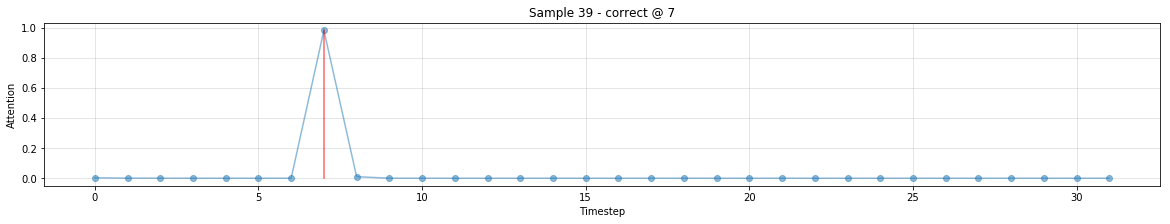

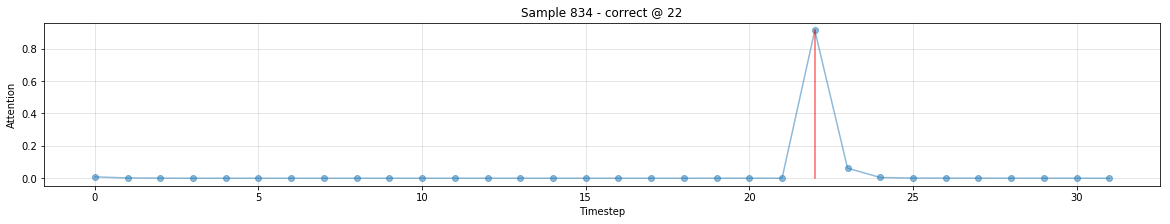

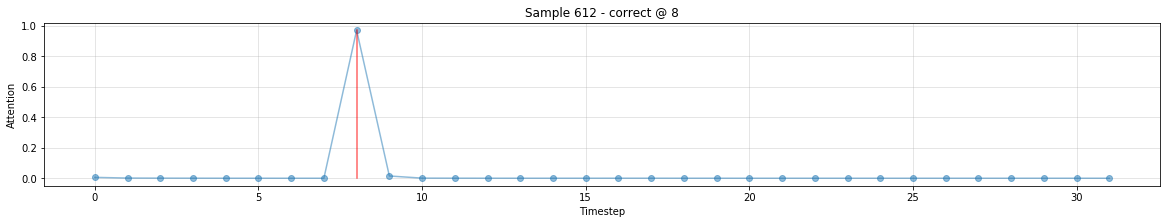

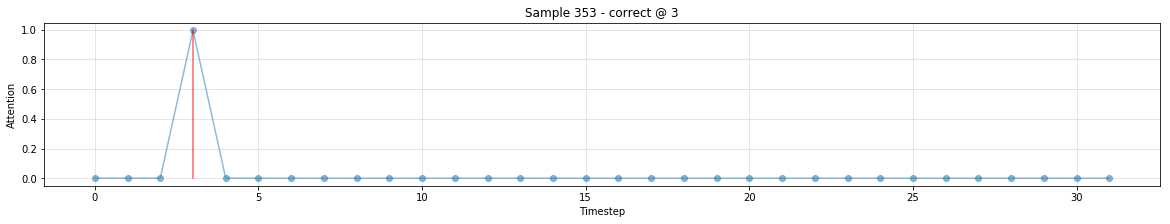

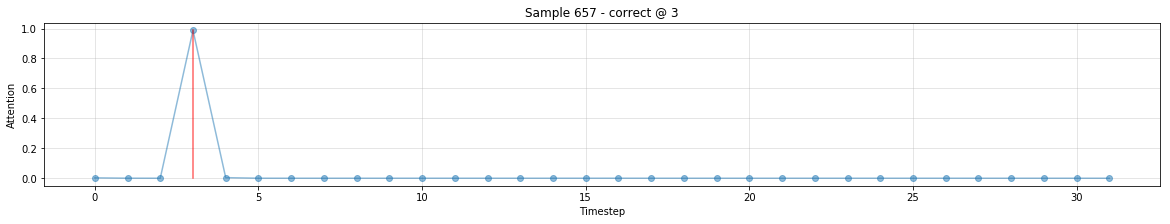

In [6]:
N_DRAWS = 5

attention_viz_model = utils.build_copy_model(attention_model)

for index in np.random.choice(range(DATA_SIZE), N_DRAWS, replace=False):
    utils.plot_attention(attention_viz_model, index, d);

## Checking loss function during training

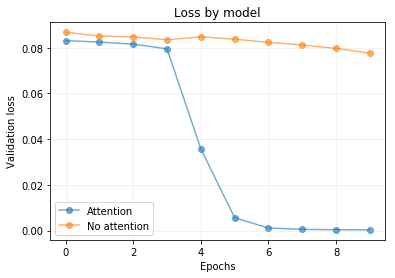

In [7]:
plt.plot(history_a.history['val_loss'], '-o', alpha=0.6, label='Attention')
plt.plot(history_v.history['val_loss'], '-o', alpha=0.6, label='No attention')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.grid(True, alpha=0.2)
plt.title('Loss by model');

## Example with sequence masking

Notice that the model is trained for fewer epochs on purpose to make the "bump" on the attention coefficients between the masked and not-masked regions visible.

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input (InputLayer)                           (None, None, 2)                         0              
____________________________________________________________________________________________________
masking_10 (Masking)                         (None, None, 2)                         0              
____________________________________________________________________________________________________
LSTM (LSTM)                                  (None, None, 5)                         160            
____________________________________________________________________________________________________
attention (AttentionLayer)                   (None, 5)                               35             
___________________________________________________________________________________________

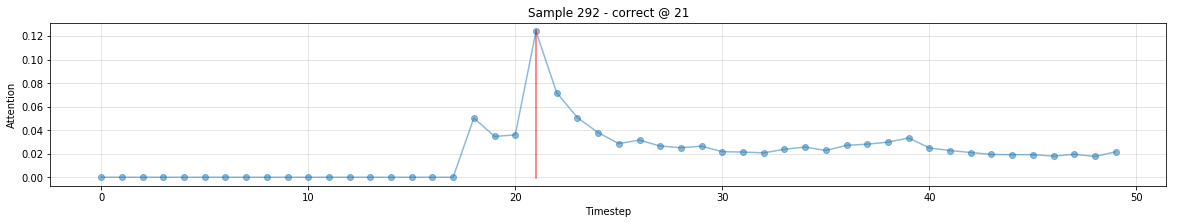

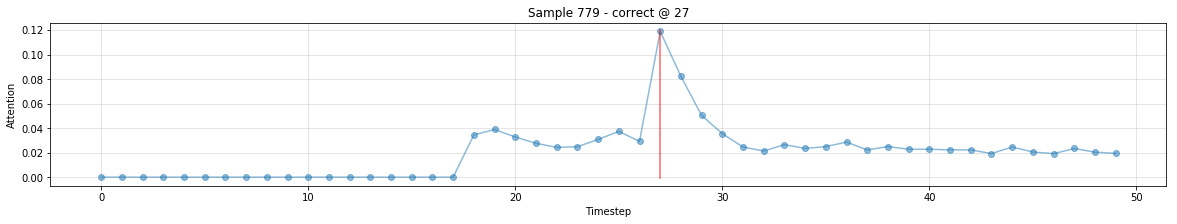

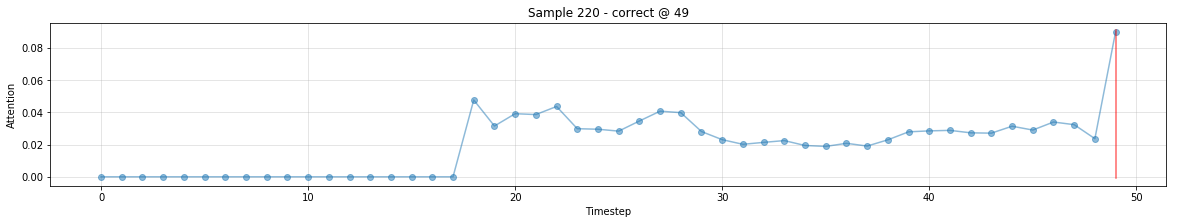

In [23]:
N_DRAWS_MASKED = 3
def build_masked_attention_model():
    sequence_in   = layers.Input(shape=(None, 2), name='input')
    masked_input  = layers.Masking()(sequence_in)
    encoder       = layers.LSTM(5, return_sequences=True, name='LSTM')(masked_input)
    attention     = AttentionLayer(name='attention')(encoder)
    output        = layers.Dense(1, activation='linear', name='output')(attention)

    model = models.Model(inputs=[sequence_in], outputs=[output])
    model.summary(line_length=100)
    model.compile(optimizers.Adam(5e-3), loss='mse')
    
    return model


# The first 18 positions of the sequence are now zeros, simulating padding
padding  = np.zeros((1000, 18, 2))
padded_d = np.concatenate([padding, d], axis=1)

masked_model = build_masked_attention_model()
masked_model.fit(padded_d[:train_index], y[:train_index],
                 validation_data=(padded_d[train_index:], y[train_index:]),
                 epochs=6,
                 batch_size=16,
                 verbose=2)

viz_masked = utils.build_copy_model(masked_model, has_masking=True)

for index in np.random.choice(range(DATA_SIZE), N_DRAWS_MASKED, replace=False):
    utils.plot_attention(viz_masked, index, padded_d);